# Imports and Python-Sat initialization

In [39]:
# Install SAT and import libraries
%pip install python-sat
import sys
import numpy as np
from itertools import combinations 
from pysat.solvers import Minisat22
from random import randint
import random
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Functions

In [36]:
def compare(guess, code):
  """Compares the secret code with a guess and returns the number of digits that
  are in the correct position.
  """
  return len([i for i in guess if i in code])

def codify(guess):
  """Encodes each element of a vector of digits into consecutive unique integers
  to be passed as clauses to the SAT solver.
  """ 
  return [(x*len(guess) + i + 1) for i,x in enumerate(guess)]

def codify_number(number, pos, size):
  """Encodes a number and its position in a vector into unique integer
  to be passed as clause to the SAT solver.
  """ 
  return number*size + pos + 1 # Starts at 1 because Minisat22 does not accept 0

def decodify(coded_vector):
  """Given an encoded vector, returns the number it represents.
  """ 
  decoded_vector = [0] * len(coded_vector)
  for number in coded_vector:
    for pos in range(len(coded_vector)):
      if (number - 1 - pos) % len(coded_vector) == 0:
        decoded_vector[pos] = (number - 1 - pos)/len(coded_vector)
  decoded_vector = ''.join(str(int(i)) for i in decoded_vector)
  return decoded_vector


def sat_feeder(s, coinc, guess):
  """ Prints the found code when the number of coincidences is equal to the
  length of the secret code vector. Otherwise, generates a new guess based on 
  the feedback of the SAT solver. 
  :s: Minisat22 solver.
  :coinc: Number of digits in their correct position.
  :guess: An attempt to guess the secret code.
  :returns: the sat solver (s), the new guess (new_guess) and wether the secret
  code has been found or not (found).
  """ 
  found = False
  new_guess = []

  if coinc == 0: # If the number of coincidenced between the guess and the
                 # secret code is 0, then remove the numbers in guess from the
                 # possible numbers vector and take new randomly chosen ones.
    for x in guess:
      if x in to_choose_from:
        to_choose_from.remove(x)
        s.add_clause([-x])
    while len(new_guess) < len(guess):
      n = random.choice(to_choose_from)
      if n not in new_guess:
        new_guess.append(n)

  elif coinc == len(guess):
    # print("Found: ", decodify(guess))
    found = True

  else: # If there is at least one match between the guess and the
        # secret code, but this hasn't been found, then add to the SAT
        # solver the corresponding clauses and take the new guess from the
        # satisfied results.

    # At least
    cnf_least = list(combinations(guess, len(guess) - int(coinc) + 1))

    # At most
    guess_neg = [-x for x in guess]
    cnf_most = list(combinations(guess_neg, 1 + int(coinc)))

    for x, y in zip(cnf_least, cnf_most):
      s.add_clause(x)
      s.add_clause(y)

    s.solve()

    for m in s.enum_models():
      m_positive = [x for x in m if x > 0 and x in to_choose_from] 
      if len(m_positive) >= len(guess):
        new_guess = m_positive[:len(guess)]
        break

  return s, new_guess, found 

# Main

In [ ]:
secret_code = str(randint(1000, 99999)) # Generates a secret code
print(f"The secret code is {secret_code}")
code_c = codify([int(x) for x in list(secret_code)]) # Encodes the secret code

# Create a vector of all possible encoded digits to make our guesses from:
to_choose_from = [codify_number(number, pos, len(secret_code)) 
                  for number in range(10) 
                  for pos in range(len(secret_code))]

# First guess:
guess_c = np.random.choice(to_choose_from,len(code_c),replace = False).tolist()


s = Minisat22()
last_number = to_choose_from[-1]
s.add_clause([last_number, -last_number]) # Makes sure the SAT solver takes into
                                          # considerations all possible numbers 

found = False

while found == False:
  coincidences = compare(guess_c, code_c)
  print(f"Guess: {decodify(guess_c)}; {coincidences} correct")
  s, guess_c, found = sat_feeder(s, coincidences, guess_c)

The secret code is 94269
Guess: 06770; 0 correct
Guess: 90910; 2 correct
Guess: 21010; 0 correct
Guess: 80834; 0 correct
Guess: 08908; 0 correct
Guess: 94051; 2 correct
Guess: 92201; 2 correct
Guess: 93201; 2 correct
Guess: 94200; 3 correct
Guess: 94203; 3 correct
Guess: 93253; 2 correct
Guess: 92252; 2 correct
Guess: 94252; 3 correct
Guess: 94200; 3 correct
Guess: 94400; 3 correct
Guess: 94200; 3 correct
Guess: 94245; 3 correct
Guess: 95600; 3 correct
Guess: 94200; 3 correct
Guess: 94267; 4 correct
Guess: 94297; 3 correct
Guess: 99200; 3 correct
Guess: 94289; 4 correct
Guess: 94280; 4 correct
Guess: 94269; 5 correct
Found:  94269


# Analysis of avg. number of iterations wrt length of secret code

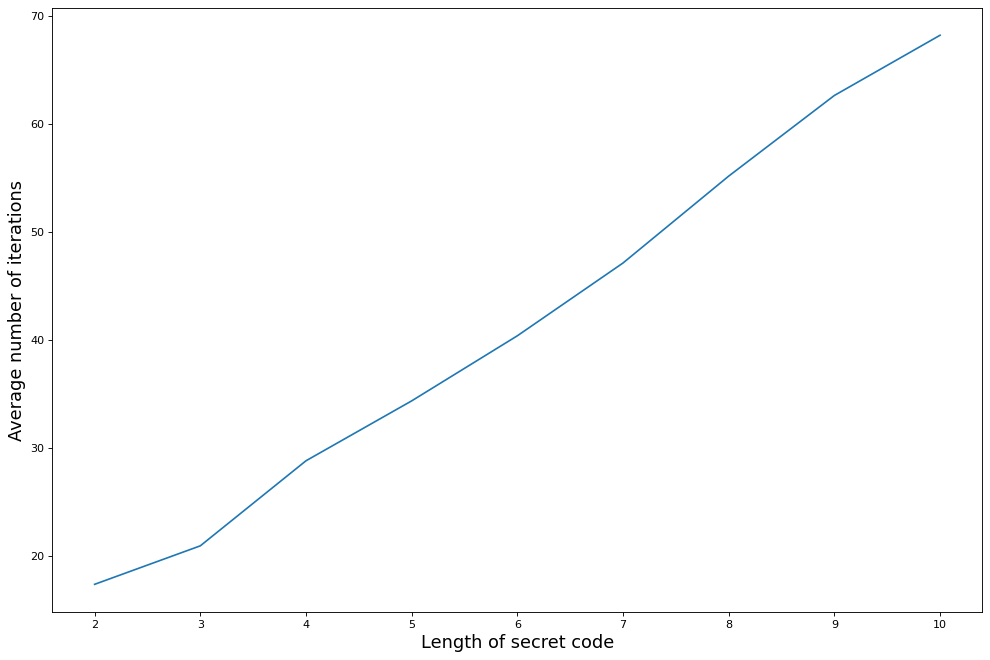

In [44]:
means = []
list_digits = [2,3,4,5,6,7,8,9,10]

for number_digits in list_digits:
  to_calc_mean = []
  for i in range(1000):
    start = 10**(number_digits) 
    end = 10**(number_digits+1)-1 
    secret_code = str(randint(start, end)) # Generates a secret code
    # print(f"The secret code is {secret_code}")
    code_c = codify([int(x) for x in list(secret_code)]) # Encodes the secret code

    # Create a vector of all possible encoded numbers to make our guesses from:
    to_choose_from = [codify_number(number, pos, len(secret_code)) 
                      for number in range(10) 
                      for pos in range(len(secret_code))]

    # First guess:
    guess_c = np.random.choice(to_choose_from,len(code_c),replace = False).tolist()
    # guess_c.append(int(to_choose_from[-1]))

    s = Minisat22()
    last_number = to_choose_from[-1]
    s.add_clause([last_number, -last_number])
    found = False

    counter = 0
    while found == False:
      counter += 1
      coincidences = compare(guess_c, code_c)
      s, guess_c, found = sat_feeder(s, coincidences, list(guess_c))

    to_calc_mean.append(counter)

  means.append(np.mean(to_calc_mean))

fig, ax = plt.subplots(figsize=(15, 10), dpi=80)
plt.plot(list_digits, means)
ax.set_ylabel("Average number of iterations", fontsize = 16)
ax.set_xlabel("Length of secret code", fontsize = 16)
plt.show()